In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from kneed import KneeLocator
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import decomposition

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 200)

Navigation vers le dossier source

In [3]:
cd Desktop/Formation_Ingenieur_Machine_Learning/P5_voelker_jean-florent

[Errno 2] No such file or directory: 'Desktop/Formation_Ingenieur_Machine_Learning/P5_voelker_jean-florent'
/Users/jfv/Desktop/Formation_Ingenieur_Machine_Learning/P5_voelker_jean-florent/P5_Voelker_Jean-Florent


In [4]:
cd ../P5_suggestion_de_tag

/Users/jfv/Desktop/Formation_Ingenieur_Machine_Learning/P5_voelker_jean-florent/P5_suggestion_de_tag


Chargement du dataset

In [5]:
RawDataset = pd.read_csv("QueryResults.csv", delimiter=",")

In [6]:
RawDataset.head()

,Title,Body,Tags
0,Jquery select this + class,<p>How can I select a class from that object <...,<jquery>
1,"Getting ""Deadlock found when trying to get loc...",<p>My Application(java spring-core) has severa...,<java><spring><hibernate>
2,Programmatically stop execution of python script?,<p>Is it possible to stop execution of a pytho...,<python>
3,How to return XML in ASP.NET?,<p>I have encountered many half-solutions to t...,<c#><asp.net><xml>
4,Unknown version of Tomcat was specified in Ecl...,<p>I want to add latest tomcat-7.0.42 in my ec...,<java><eclipse><tomcat>


In [60]:
row=1000
RawDataset['Title'][row], RawDataset['Body'][row]

('How do you replace all the occurrences of a certain character in a string?',
 "<p>I am reading a csv into <code>a</code>:</p>\n\n<pre><code>import csv\nimport collections\nimport pdb\nimport math\nimport urllib\n\ndef do_work():\n  a=get_file('c:/pythonwork/cds/cds.csv')\n  a=remove_chars(a)\n  print a[0:10]\n\ndef get_file(start_file): #opens original file, reads it to array\n  with open(start_file,'rb') as f:\n    data=list(csv.reader(f))\n  return (data)\n\ndef remove_chars(a):\n  badchars=['a','b','c','d']\n  for row in a:\n    for letter in badchars:\n      row[8].replace(letter,'')\n  return a\n</code></pre>\n\n<p>I would like to replace all occurrences of <code>['a','b','c','d']</code> in the 8th element of the line with empty string. the <code>remove_chars</code> function is not working.</p>\n\n<p>Is there a better way to do this?</p>\n")

Je retire les lignes avec une colonne nulle.

In [7]:
RawDataset_V2=RawDataset.dropna()

#### Restriction 

In [8]:
RawDataset_V2=RawDataset_V2.iloc[:5000,:]

## Analyse de la variable cible "Tags"

Création d'une fonction de nettoyage et nettoyage de "Tags"

In [9]:
def tags_to_words(raw_text):
    raw_text=raw_text.replace("><"," ").replace("<","").replace(">","")
    
    return raw_text.split(" ")

In [10]:
RawDataset_V2['Tags']=RawDataset_V2['Tags'].apply(tags_to_words)

In [11]:
RawDataset_V2['Tags'].head()

0                     [jquery]
1    [java, spring, hibernate]
2                     [python]
3           [c#, asp.net, xml]
4      [java, eclipse, tomcat]
Name: Tags, dtype: object

Création d'une colonne qui compte le nombre de tags associés à la question

In [12]:
RawDataset_V2['TagsCount'] = RawDataset_V2['Tags'].apply(lambda item: len(item))

J'affiche le nombre de tags par question:

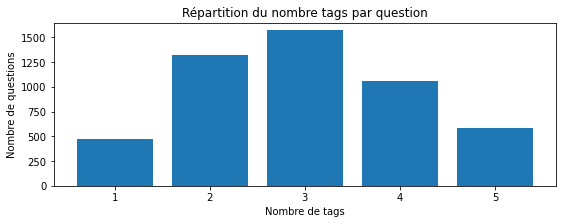

In [13]:
nb_tag_min=min(RawDataset_V2['TagsCount'])
nb_tag_max=max(RawDataset_V2['TagsCount'])


plt.figure(figsize=(9, 3))
plt.bar(RawDataset_V2['TagsCount'].value_counts().index,RawDataset_V2['TagsCount'].value_counts())
plt.title('Répartition du nombre tags par question')
plt.xlabel('Nombre de tags')
plt.ylabel('Nombre de questions')
plt.show()

Il y a entre 1 et 5 tags à prédire pour chaque question, la médiane se situant vers 3.

Je regarde maintenant l'utilisation de chaque tag sur l'ensemble des questions. 

In [14]:
tags_to_be_vectorized = RawDataset_V2['Tags'].apply(lambda item: " ".join(x for x in item))

count_vect = CountVectorizer(tokenizer=lambda text : text.split(), binary=True)
tags_vectorized = count_vect.fit_transform(tags_to_be_vectorized)
tags_vectorized_df = pd.DataFrame(tags_vectorized.toarray())

In [15]:
tags_count = tags_vectorized.shape[1]

#Comptage du nombre fois où chaque tag est utilisé dans une question:
tags_used_count = tags_vectorized.sum(axis=0).tolist()[0]

#Tri des tags de plus utilisé au moins utilisé
tags_sorted = sorted(range(tags_count), key=lambda i: np.array(tags_used_count)[i], reverse=True)


In [16]:
sorted_tags_vectorized_df=tags_vectorized_df.reindex(columns=tags_sorted)

J'ai désormais un DataFrame dont les colonnes représente l'utilisation de chaque tag en fonction de chaque question (ligne) et ces colonnes sont classées du tag le plus utilisé au moins utilisé.

In [17]:
sorted_tags_vectorized_df

,1307,1296,1982,345,1134,1338,2309,69,554,1857,3,2319,349,2397,1615,993,207,344,2055,1436,2779,212,279,1256,1354,...,2827,2828,2830,2832,2833,2834,2839,2841,2844,2845,2846,2848,2849,2850,2851,2853,2854,2855,2857,2858,2859,2861,2862,2863,2864
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Je vais maintenant sélectionner les N premières colonnes.

In [18]:
tags_nb = sorted_tags_vectorized_df.shape[1]
question_nb = sorted_tags_vectorized_df.shape[0]
tags_selectivity = {}

for tags_qty in np.arange(10,tags_nb,10):
    N_tags_df = sorted_tags_vectorized_df.iloc[:,:tags_qty]
    #Je compte le nombre de tag pour chaque ligne (question)
    tags_used_count = N_tags_df.sum(axis=1).tolist()
    tags_selectivity_percentage = 100*np.count_nonzero(tags_used_count)/question_nb
    tags_selectivity[tags_qty] = tags_selectivity_percentage
    

Courbe "Effet Pareto"

 Localisation du point de courbure maximum et récupération du nombre de Tags correspondante(kneedle.knee_y)

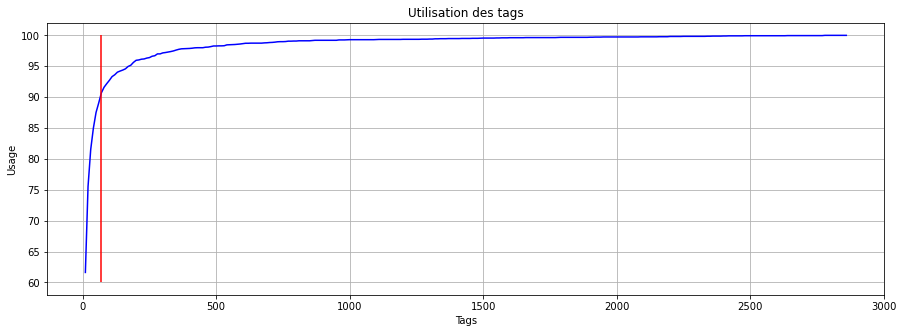

In [19]:
sensitivity = 0.1

kneedle = KneeLocator(list(tags_selectivity.keys()), list(
    tags_selectivity.values()), S=sensitivity, curve="concave", direction="increasing")

plt.figure(figsize=(15, 5))
plt.plot(tags_selectivity.keys(),tags_selectivity.values(), c="blue")
plt.vlines(70,60,100, color='red')
#plt.vlines(kneedle.knee,min(tags_selectivity.values()),100, color="red", linestyle="--",label="Tag nb : "+str(kneedle.knee))
plt.title('Utilisation des tags')
plt.xlabel('Tags')
plt.ylabel('Usage')
#plt.legend(loc="lower right")
plt.grid()
plt.show()

In [20]:
tags_selectivity[70]

90.7

In [21]:
nombre_tags=70

Avec les 70 premiers tags nous couvront 90% des questions

In [22]:
y=sorted_tags_vectorized_df.iloc[:,:nombre_tags]

J'ai un pourcentage de questions qui vont rester sans tags atribués. Je leur attribue la tag "Autres"-id: tags_nb

In [23]:
y.insert(loc=y.shape[1],column=tags_nb, value=0, allow_duplicates=True)

In [24]:
row_without_tag=y[tags_nb][y.sum(axis=1)==0]

In [25]:
for index in row_without_tag.index.values:
    y.at[index,tags_nb]=1

In [26]:
liste_tags_retenus = []
dictionnaire_tags = count_vect.vocabulary_
#Je rajoute le tag "out_of_selected_tag_list"avec pour id tags_nb
dictionnaire_tags['Autres']=tags_nb

# Je liste séparément les clefs et les valeurs des tags
key_list = list(dictionnaire_tags.keys())
val_list = list(dictionnaire_tags.values())

for tag_number in y.columns:
    position = val_list.index(tag_number)
    liste_tags_retenus.append(key_list[position])

In [27]:
y=pd.DataFrame(y.to_numpy(),columns=liste_tags_retenus)


## Combinaison des variables "Body" et "Title"

Je vais concatener Les champs "Title" et "Body" car le titre est sensé contenir des mots important pour caractériser le texte et aussi parce qu'il arrive qu'un auteur ne répète pas dans "body" les informations saisies dans "Title".

In [28]:
RawDataset_V2['Body'] = RawDataset_V2['Title'] + '-' +  RawDataset_V2['Body']

# Nettoyage du texte - preprocessing

In [29]:
def body_to_words(raw_text):

    # 1. Retirer les balises HTML
    review_text = BeautifulSoup(raw_text,"html.parser").get_text() 
    #
    # 2. Retirer les caractères non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. convertir les lettres en minuscules, split into individual words
    words = letters_only.lower().split()                              
    
   
    # 4. Création d'un set de stopwords
    stops = set(stopwords.words("english"))        
    
    # 5. Retirer les stopwords du body
    words = [w for w in words if not w in stops]   
    
    # 6. Retirer les répétitions de lettres type : "aaa", "bbbbbbb", etc...
    words = [w for w in words if bool(re.search(r"(.)\1+",w))==False]

    
    #J'initialise un lemminizer celui-ci va plus loin qu'un stemmer en effectuant un contextualisation
    lemmatizer = WordNetLemmatizer()
    
    # loop for stemming each word
    # in string array at ith row   
    meaningful_words = [lemmatizer.lemmatize(word) for word in words]
    
    # 6. Jointure de tous les mots conservés et retour du résultat 
    return( " ".join(meaningful_words))   


Application des fonctions de nettoyage à chaque ligne du DataFrame

In [30]:
CleanDataset=pd.DataFrame()
CleanDataset['Body'] = RawDataset_V2['Body'].apply(body_to_words)

In [31]:
RawDataset_V2['Body'].head()

0    Jquery select this + class-<p>How can I select...
1    Getting "Deadlock found when trying to get loc...
2    Programmatically stop execution of python scri...
3    How to return XML in ASP.NET?-<p>I have encoun...
4    Unknown version of Tomcat was specified in Ecl...
Name: Body, dtype: object

In [32]:
CleanDataset['Body'].head()

0    jquery select select object click function vis...
1    deadlock found trying get lock try restarting ...
2    stop execution python script stop execution py...
3    return xml asp net encountered many half solut...
4    unknown version tomcat specified eclipse want ...
Name: Body, dtype: object

In [33]:
X=CleanDataset['Body']

# Traitement des données d'entrée

Je réalise un Bag of Words combiné à une TF-IDF (term frequency-inverse document frequency)

In [52]:
tfidf_vectorizer = TfidfVectorizer(min_df=0.001,max_df=0.75,  ngram_range=(1, 1))
X_vectorized = tfidf_vectorizer.fit_transform(X)

In [53]:
pd.DataFrame(X_vectorized.toarray(), columns=tfidf_vectorizer.get_feature_names())

/Users/jfv/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ab,abc,ability,able,absolute,absolutely,abstract,ac,achieve,achieved,achieving,act,action,actionbar,actionbaractivity,actionlink,actionresult,activate,active,activerecord,activex,activity,activitythread,actual,ad,...,xlsx,xml,xmldocument,xmlns,xmlschema,xmx,xp,xpath,xrange,xsd,xsi,xsl,xyz,yaml,year,yes,yesterday,yet,yield,youtube,za,zero,zip,zone,zygoteinit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.014783,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.487868,0.091679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.096531,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.371333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Nous obtenons donc un dataset d'entrée de 2966 variables:

In [40]:
len(tfidf_vectorizer.get_feature_names())

/Users/jfv/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


2966

In [41]:
for word in tfidf_vectorizer.get_feature_names():
    print(word)

ab
abc
ability
able
absolute
absolutely
abstract
ac
achieve
achieved
achieving
act
action
actionbar
actionbaractivity
actionlink
actionresult
activate
active
activerecord
activex
activity
activitythread
actual
ad
adapter
adb
adjust
admin
administrator
adt
advance
advanced
advantage
advice
advise
ae
aes
af
afterwards
age
agent
ago
ahead
ajax
al
album
alert
alex
algorithm
alias
align
aligned
alignment
alive
almost
alone
along
alpha
already
also
alt
alter
alternate
alternative
alternatively
although
always
amazon
ambiguous
amd
among
amount
amp
ampersand
anaconda
anchor
android
androidruntime
angular
angularjs
animal
animate
animated
animation
anonymous
another
ansi
answer
answered
ant
anybody
anymore
anyone
anything
anyway
anyways
anywhere
apache
apart
api
apis
apk
apology
apr
apt
ar
arbitrary
arch
architecture
archive
area
arg
argc
args
argument
argv
arial
arithmetic
arm
around
art
article
artifact
artifactid
asax
asc
ascending
ask
asked
asking
asks
asp
aspect
aspx
async
asynchronous
asy

month
mostly
mouse
move
moved
movie
moving
moz
mp
msdn
msg
much
multi
multiline
multipart
multiple
multiply
music
must
mutable
mv
mvc
mvn
mydb
myfile
mylist
myobject
myproject
mysite
mysql
mysqldump
mysqli
mystring
mytable
myurl
na
name
named
namespace
namespaces
naming
native
natively
nativestart
natural
nature
nav
navbar
navigate
navigating
navigation
nbsp
nd
near
nearest
nearly
neat
negative
neither
nested
net
netbeans
network
networking
neutral
never
new
newbie
newer
newinstance
newline
newlines
newly
news
next
ng
nginx
ngoninit
nice
nicely
nil
node
nodejs
non
none
nonetype
normal
notation
note
notepad
nothing
notice
noticed
notification
notified
notify
nov
novice
np
npm
nt
nth
num
number
numeric
numerical
numerous
numpy
nvarchar
oauth
obj
object
objective
observable
obtain
obvious
obviously
oct
octet
often
oh
ok
okay
old
older
onchange
onclick
onclicklistener
oncreate
oncreateview
one
onkeyup
online
onload
onto
opacity
opaque
open
opencv
opened
opening
opera
operating
operation
op

Je réalise un Bag of Words combiné à une TF-IDF dédié au model Latent Dirichlet Allocation

In [42]:
tfidf_vectorizer_lda = TfidfVectorizer(min_df=45,max_df=0.75,  ngram_range=(1, 1))
X_vectorized_lda = tfidf_vectorizer_lda.fit_transform(X)
len(tfidf_vectorizer_lda.get_feature_names())

621

Sauvegarde des données d'entrée pour une démarche non-supervisée

In [43]:
pd.DataFrame(X_vectorized_lda.toarray(), columns=tfidf_vectorizer_lda.get_feature_names()).to_csv('df_question_cleaned_without_pca.csv')

### Réduction de dimension PCA:

Je ne standardise pas les variables issues du tf-idf, car les valeurs sont toutes exprimées selon la même échelle.

In [44]:
n_comp = min(len(tfidf_vectorizer.get_feature_names()),X_vectorized.shape[0])
pca = decomposition.PCA(n_components=n_comp).fit(X_vectorized.toarray())
X_vectorized_projected = pca.transform(X_vectorized.toarray())

Je vais conserver les composantes dont la variance rattachée est supérieures à 1/nombre de composante (critère de Kaiser)

In [45]:
kaiser_critere = 1/n_comp
i=0
limit_found = False
nombre_variables=0

for variance_ratio in pca.explained_variance_ratio_:
    i+=1
    #print(varaince_ratio)
    if variance_ratio < kaiser_critere and limit_found == False:
        limit_found = True
        print("Valeur du critère de Kaiser: "+str(kaiser_critere))
        print("Variance expliquée : {:.1f}%".format(100*np.sum(pca.explained_variance_ratio_[:i-1])))
        nombre_variables=i
        print("Nombre de composantes à retenir: "+str(nombre_variables))

Valeur du critère de Kaiser: 0.00033715441672285906
Variance expliquée : 79.0%
Nombre de composantes à retenir: 773


En graphant la variance cumulée, j'observe que j'explique 79% de la variance totale avec 773 variables sur 2966.

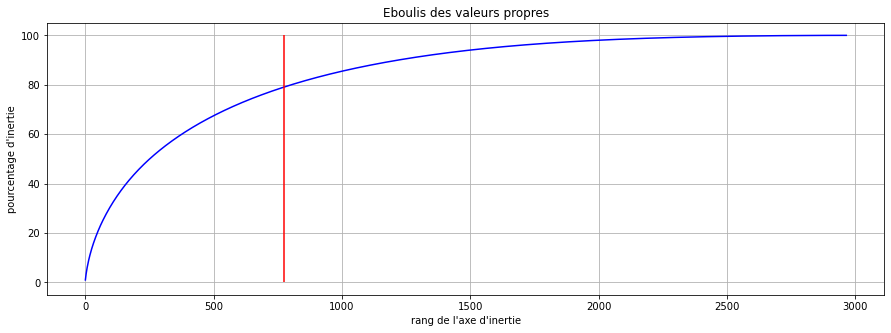

In [46]:
scree = pca.explained_variance_ratio_*100

plt.figure(figsize=(15, 5))
plt.plot(np.arange(len(scree)),scree.cumsum(), c="blue")
plt.vlines(nombre_variables,0,100, color='red')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.grid()
plt.show(block=False)

Je limite donc mon dataset d'entrainement et de test à 773 variables.

In [47]:
nombre_variables

773

In [48]:
X_vectorized_projected=X_vectorized_projected[:,:nombre_variables]

# Sauvegarde des données d'entrée et de sortie nettoyées

Sauvegarde des données d'entrée pour une démarche supervisée

In [49]:
pd.DataFrame(X_vectorized_projected).to_csv('df_question_cleaned.csv')

Sauvegarde des données de sortie

In [50]:
y.to_csv('df_tags_cleaned.csv')